In [5]:
!pip install pyreadstat

In [6]:
import pyreadstat
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    confusion_matrix, precision_recall_curve, average_precision_score,
    roc_curve, roc_auc_score
)
import matplotlib.pyplot as plt

In [7]:
# --- Step 1: Load .sav data ---
df, meta = pyreadstat.read_sav("CAD.sav")

In [8]:
df.columns


Index(['Age', 'sex', 'cp', 'trestbps', 'chol', 'cigs', 'years', 'fbs',
       'famhist', 'restecg', 'thalach', 'thalrest', 'tpeakbps', 'tpeakbpd',
       'trestbpd', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'num',
       'outcome'],
      dtype='object')

In [9]:
# Assume the last column is the target (adjust if needed)
X = df.drop(columns=df.columns[-2:])
y = df[df.columns[-1]]

In [10]:
X.columns

Index(['Age', 'sex', 'cp', 'trestbps', 'chol', 'cigs', 'years', 'fbs',
       'famhist', 'restecg', 'thalach', 'thalrest', 'tpeakbps', 'tpeakbpd',
       'trestbpd', 'exang', 'oldpeak', 'slope', 'ca', 'thal'],
      dtype='object')

In [11]:
len(X)

282

In [13]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="mean")  # you can use "median" or "most_frequent"
X_imputed = imputer.fit_transform(X)

# Keep as DataFrame (optional, for readability)
X = pd.DataFrame(X_imputed, columns=X.columns, index=X.index)

In [19]:
# --- Step 2: Train/Test Split ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# --- Step 3: Logistic Regression ---
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [20]:
# --- Step 4: Confusion Matrix ---
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print(f"TP = {tp}, FP = {fp}, TN = {tn}, FN = {fn}")

# --- Step 5: Precision-Recall Curve (PRC) ---
precision, recall, _ = precision_recall_curve(y_test, y_prob)
auprc = average_precision_score(y_test, y_prob)

TP = 32, FP = 8, TN = 39, FN = 6


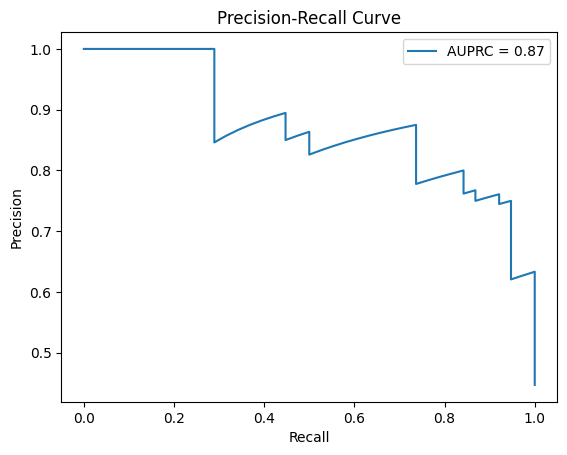

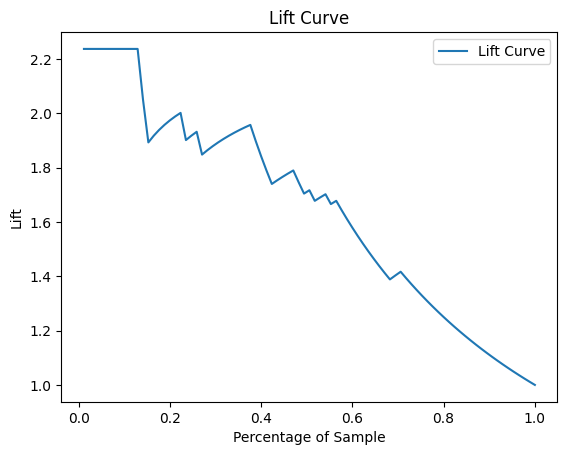

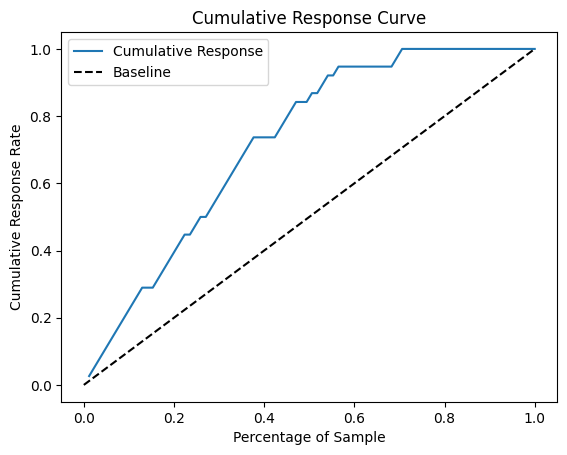

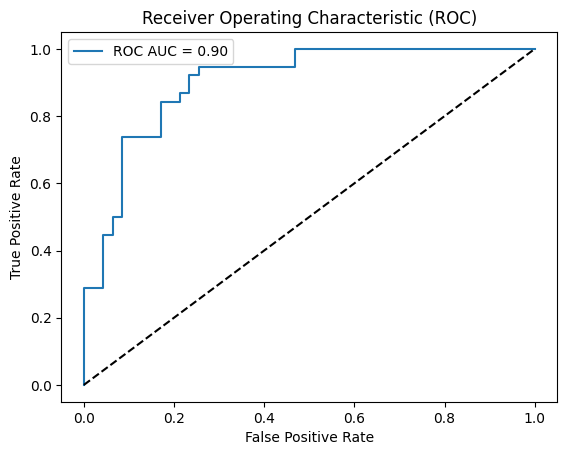

In [21]:
plt.figure()
plt.plot(recall, precision, label=f'AUPRC = {auprc:.2f}')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()

# --- Step 6: Lift Curve ---
df_lift = pd.DataFrame({"y_true": y_test, "y_prob": y_prob})
df_lift = df_lift.sort_values("y_prob", ascending=False).reset_index(drop=True)
df_lift["cum_response"] = df_lift["y_true"].cumsum()
df_lift["perc_samples"] = (np.arange(len(df_lift)) + 1) / len(df_lift)
df_lift["lift"] = df_lift["cum_response"] / (df_lift["perc_samples"] * df_lift["y_true"].sum())

plt.figure()
plt.plot(df_lift["perc_samples"], df_lift["lift"], label="Lift Curve")
plt.xlabel("Percentage of Sample")
plt.ylabel("Lift")
plt.title("Lift Curve")
plt.legend()
plt.show()

# --- Step 7: Cumulative Response Curve (CRC) ---
df_lift["cum_response_rate"] = df_lift["cum_response"] / df_lift["y_true"].sum()

plt.figure()
plt.plot(df_lift["perc_samples"], df_lift["cum_response_rate"], label="Cumulative Response")
plt.plot([0,1],[0,1], 'k--', label="Baseline")
plt.xlabel("Percentage of Sample")
plt.ylabel("Cumulative Response Rate")
plt.title("Cumulative Response Curve")
plt.legend()
plt.show()

# --- Step 8: ROC Curve ---
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = roc_auc_score(y_test, y_prob)

plt.figure()
plt.plot(fpr, tpr, label=f'ROC AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC)")
plt.legend()
plt.show()

## SVM model

In [22]:
from sklearn.svm import SVC

# --- Step 3: SVM Classifier ---
# Use probability=True if you want to get probabilities like with logistic regression
model = SVC(kernel='rbf', C=1.0, probability=True, random_state=42)

# Fit the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Predicted probabilities for positive class
y_prob = model.predict_proba(X_test)[:, 1]

In [23]:
# --- Step 4: Confusion Matrix ---
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print(f"TP = {tp}, FP = {fp}, TN = {tn}, FN = {fn}")

# --- Step 5: Precision-Recall Curve (PRC) ---
precision, recall, _ = precision_recall_curve(y_test, y_prob)
auprc = average_precision_score(y_test, y_prob)

TP = 13, FP = 4, TN = 43, FN = 25


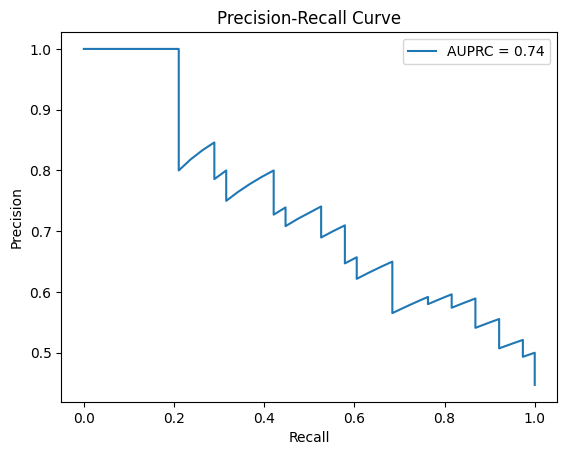

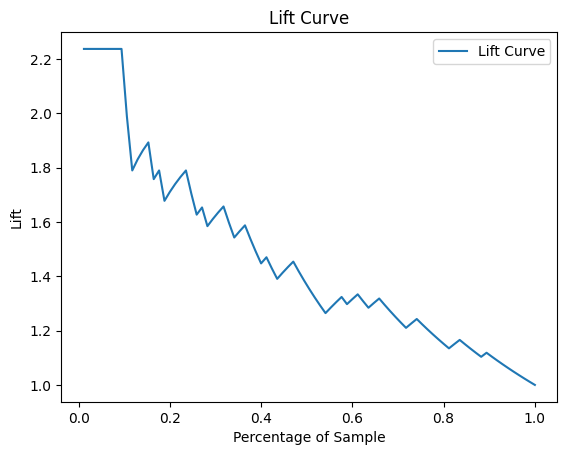

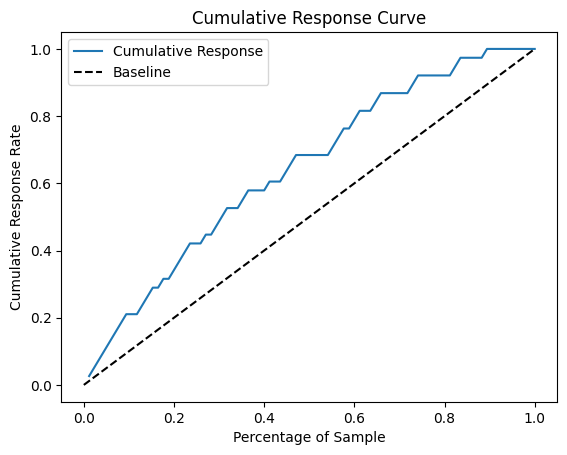

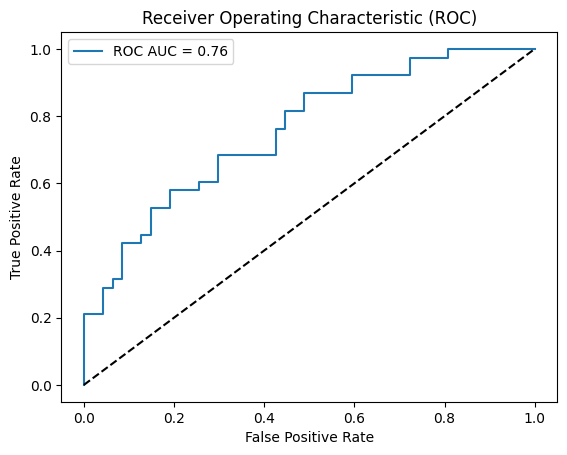

In [24]:
plt.figure()
plt.plot(recall, precision, label=f'AUPRC = {auprc:.2f}')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()

# --- Step 6: Lift Curve ---
df_lift = pd.DataFrame({"y_true": y_test, "y_prob": y_prob})
df_lift = df_lift.sort_values("y_prob", ascending=False).reset_index(drop=True)
df_lift["cum_response"] = df_lift["y_true"].cumsum()
df_lift["perc_samples"] = (np.arange(len(df_lift)) + 1) / len(df_lift)
df_lift["lift"] = df_lift["cum_response"] / (df_lift["perc_samples"] * df_lift["y_true"].sum())

plt.figure()
plt.plot(df_lift["perc_samples"], df_lift["lift"], label="Lift Curve")
plt.xlabel("Percentage of Sample")
plt.ylabel("Lift")
plt.title("Lift Curve")
plt.legend()
plt.show()

# --- Step 7: Cumulative Response Curve (CRC) ---
df_lift["cum_response_rate"] = df_lift["cum_response"] / df_lift["y_true"].sum()

plt.figure()
plt.plot(df_lift["perc_samples"], df_lift["cum_response_rate"], label="Cumulative Response")
plt.plot([0,1],[0,1], 'k--', label="Baseline")
plt.xlabel("Percentage of Sample")
plt.ylabel("Cumulative Response Rate")
plt.title("Cumulative Response Curve")
plt.legend()
plt.show()

# --- Step 8: ROC Curve ---
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = roc_auc_score(y_test, y_prob)

plt.figure()
plt.plot(fpr, tpr, label=f'ROC AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC)")
plt.legend()
plt.show()

## XGBoost model

In [25]:
# --- Step 3: XGBoost Classifier ---
from xgboost import XGBClassifier

# Initialize the model
model = XGBClassifier(
    n_estimators=100,    # number of trees
    learning_rate=0.1,   # step size shrinkage
    max_depth=6,         # maximum tree depth
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'  # needed to suppress warning in recent XGBoost versions
)

# Fit the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Predicted probabilities for positive class
y_prob = model.predict_proba(X_test)[:, 1]


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [09:36:59] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [09:50:22] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


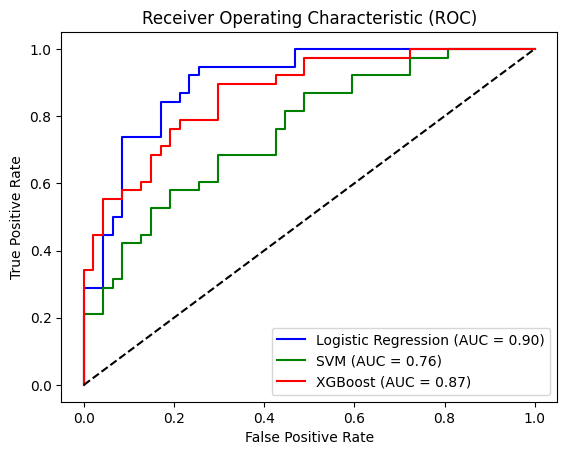

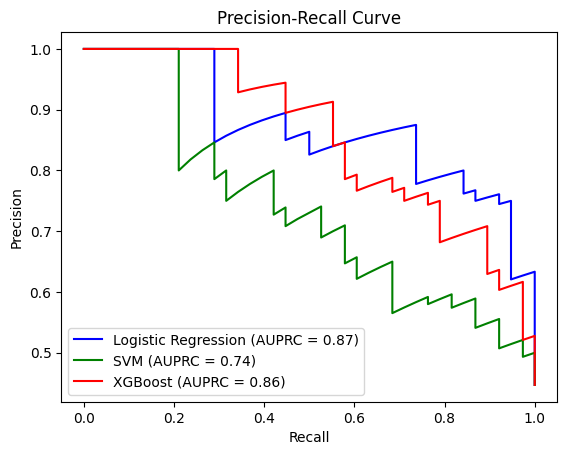

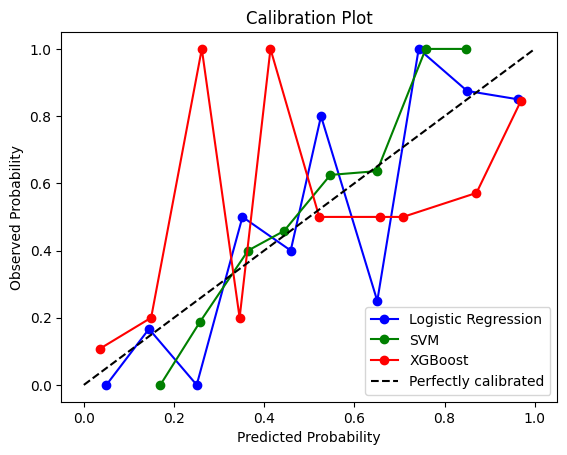

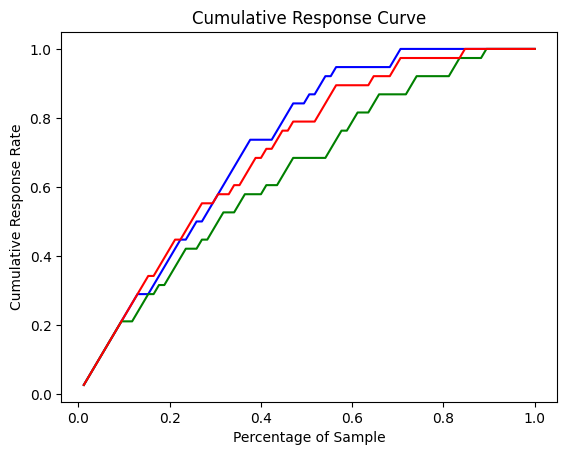

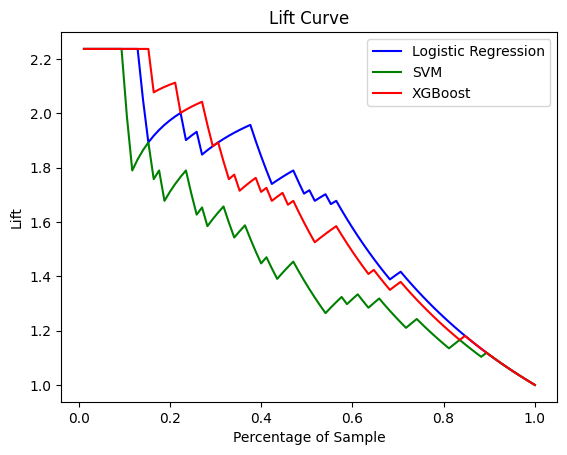

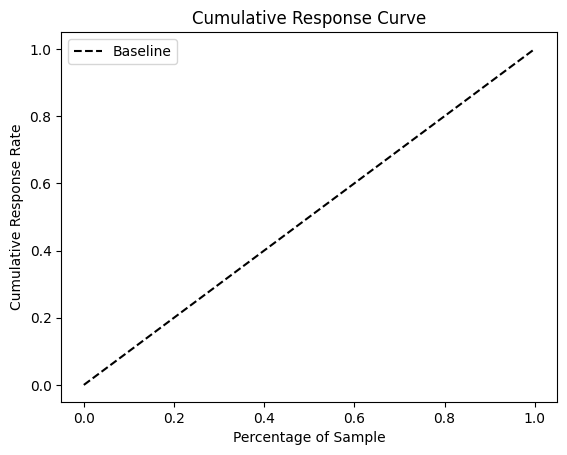

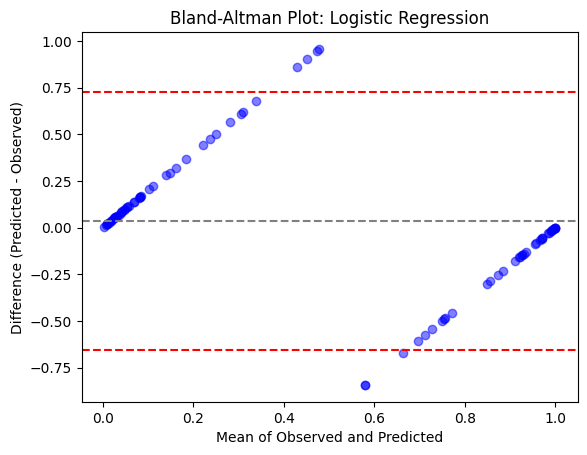

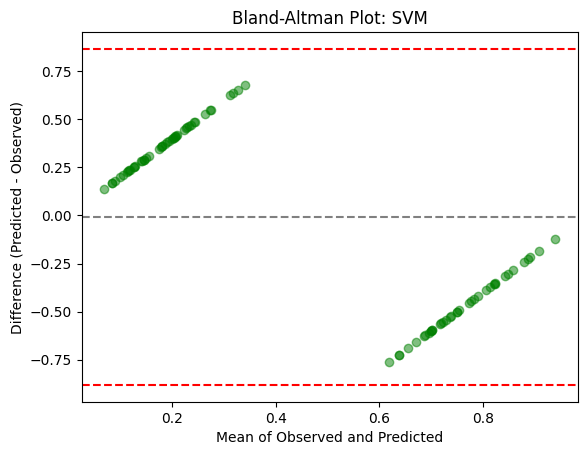

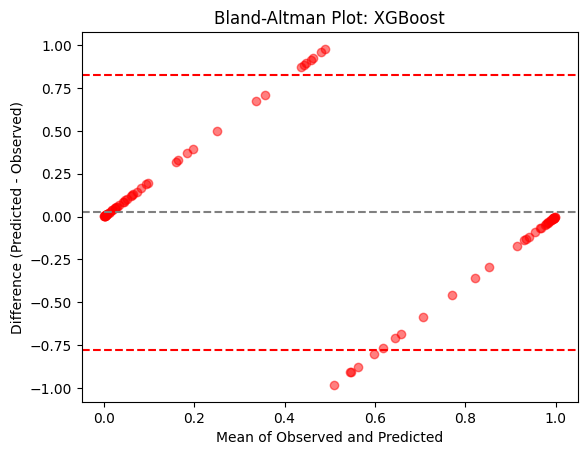

In [15]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, average_precision_score
from sklearn.calibration import calibration_curve

# --- Step 2: Train/Test Split ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# --- Step 3: Define Models ---
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "SVM": SVC(kernel='rbf', C=1.0, probability=True, random_state=42),
    "XGBoost": XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=6,
                             random_state=42, use_label_encoder=False, eval_metric='logloss')
}

colors = {"Logistic Regression": "blue", "SVM": "green", "XGBoost": "red"}

# --- Initialize storage for probabilities ---
y_probs = {}

# --- Fit models and get probabilities ---
for name, model in models.items():
    model.fit(X_train, y_train)
    y_probs[name] = model.predict_proba(X_test)[:, 1]

# --- Step 4: ROC Curve ---
plt.figure()
for name, probs in y_probs.items():
    fpr, tpr, _ = roc_curve(y_test, probs)
    auc = roc_auc_score(y_test, probs)
    plt.plot(fpr, tpr, color=colors[name], label=f"{name} (AUC = {auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC)")
plt.legend()
plt.show()

# --- Step 5: Precision-Recall Curve ---
plt.figure()
for name, probs in y_probs.items():
    precision, recall, _ = precision_recall_curve(y_test, probs)
    auprc = average_precision_score(y_test, probs)
    plt.plot(recall, precision, color=colors[name], label=f"{name} (AUPRC = {auprc:.2f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()

# --- Step 6: Calibration Plot ---
plt.figure()
for name, probs in y_probs.items():
    prob_true, prob_pred = calibration_curve(y_test, probs, n_bins=10)
    plt.plot(prob_pred, prob_true, marker='o', color=colors[name], label=name)
plt.plot([0, 1], [0, 1], 'k--', label="Perfectly calibrated")
plt.xlabel("Predicted Probability")
plt.ylabel("Observed Probability")
plt.title("Calibration Plot")
plt.legend()
plt.show()

# --- Step 7: Lift Curve & Cumulative Response Curve ---
plt.figure()
plt.title("Lift Curve")
plt.xlabel("Percentage of Sample")
plt.ylabel("Lift")

plt.figure()
plt.title("Cumulative Response Curve")
plt.xlabel("Percentage of Sample")
plt.ylabel("Cumulative Response Rate")

for name, probs in y_probs.items():
    df_lift = pd.DataFrame({"y_true": y_test, "y_prob": probs})
    df_lift = df_lift.sort_values("y_prob", ascending=False).reset_index(drop=True)
    df_lift["cum_response"] = df_lift["y_true"].cumsum()
    df_lift["perc_samples"] = (np.arange(len(df_lift)) + 1) / len(df_lift)
    df_lift["lift"] = df_lift["cum_response"] / (df_lift["perc_samples"] * df_lift["y_true"].sum())
    df_lift["cum_response_rate"] = df_lift["cum_response"] / df_lift["y_true"].sum()

    # Plot Lift Curve
    plt.figure(1)
    plt.plot(df_lift["perc_samples"], df_lift["lift"], color=colors[name], label=name)

    # Plot Cumulative Response Curve
    plt.figure(2)
    plt.plot(df_lift["perc_samples"], df_lift["cum_response_rate"], color=colors[name], label=name)

# Finalize Lift Curve
plt.figure(1)
plt.legend()
plt.title("Lift Curve")
plt.xlabel("Percentage of Sample")
plt.ylabel("Lift")
plt.show()

# Finalize Cumulative Response Curve
plt.figure(2)
plt.plot([0,1],[0,1], 'k--', label="Baseline")
plt.legend()
plt.title("Cumulative Response Curve")
plt.xlabel("Percentage of Sample")
plt.ylabel("Cumulative Response Rate")
plt.show()

# --- Step 8: Bland-Altman Plot (for each model) ---
for name, probs in y_probs.items():
    mean = (probs + y_test.values) / 2
    diff = probs - y_test.values
    md = np.mean(diff)
    sd = np.std(diff, axis=0)

    plt.figure()
    plt.scatter(mean, diff, color=colors[name], alpha=0.5)
    plt.axhline(md, color='gray', linestyle='--')
    plt.axhline(md + 1.96*sd, color='red', linestyle='--')
    plt.axhline(md - 1.96*sd, color='red', linestyle='--')
    plt.xlabel("Mean of Observed and Predicted")
    plt.ylabel("Difference (Predicted - Observed)")
    plt.title(f"Bland-Altman Plot: {name}")
    plt.show()


## Combine plots

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [10:06:37] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


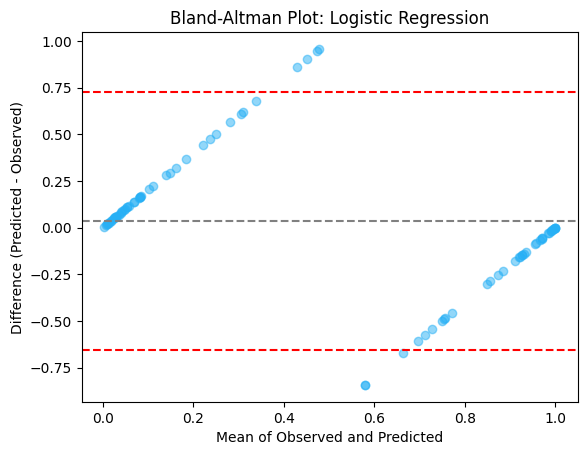

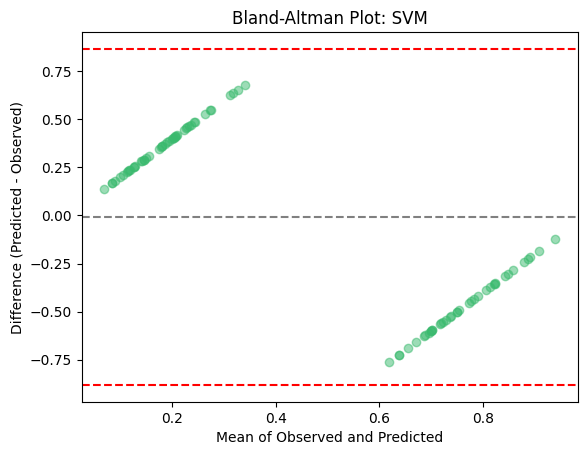

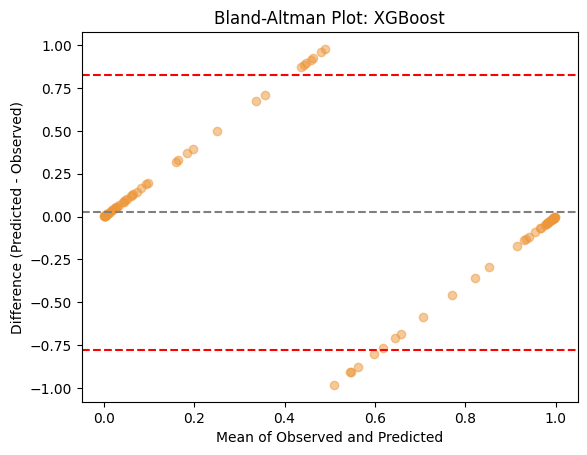

In [24]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, average_precision_score
from sklearn.calibration import calibration_curve

# --- Step 2: Train/Test Split ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# --- Step 3: Define Models ---
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "SVM": SVC(kernel='rbf', C=1.0, probability=True, random_state=42),
    "XGBoost": XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=6,
                             random_state=42, use_label_encoder=False, eval_metric='logloss')
}

colors = {"Logistic Regression": "#27B0F5",  # light blue
          "SVM": "#3ABA6E",                  # light green
          "XGBoost": "#ED9639"}             # orange


# --- Initialize storage for probabilities ---
y_probs = {}

# --- Fit models and get probabilities ---
for name, model in models.items():
    model.fit(X_train, y_train)
    y_probs[name] = model.predict_proba(X_test)[:, 1]





# --- Step 7: Bland-Altman Plot (for each model) ---
for name, probs in y_probs.items():
    mean = (probs + y_test.values) / 2
    diff = probs - y_test.values
    md = np.mean(diff)
    sd = np.std(diff, axis=0)

    plt.figure()
    plt.scatter(mean, diff, color=colors[name], alpha=0.5)
    plt.axhline(md, color='gray', linestyle='--')
    plt.axhline(md + 1.96*sd, color='red', linestyle='--')
    plt.axhline(md - 1.96*sd, color='red', linestyle='--')
    plt.xlabel("Mean of Observed and Predicted")
    plt.ylabel("Difference (Predicted - Observed)")
    plt.title(f"Bland-Altman Plot: {name}")
    plt.show()


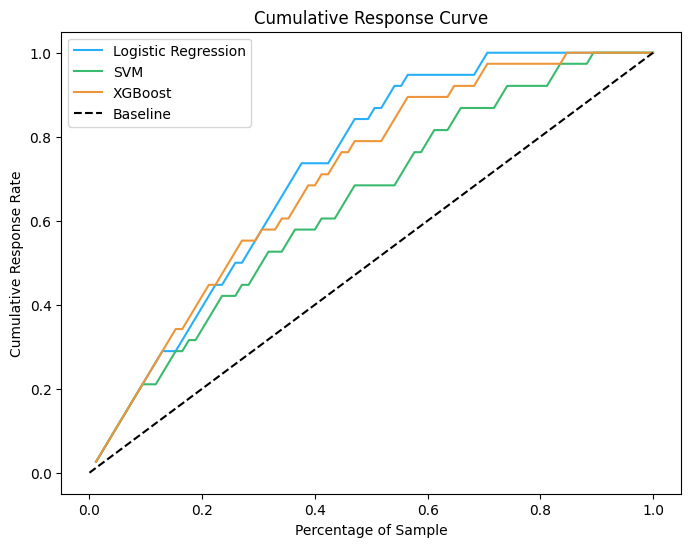

In [34]:
# --- Cumulative Response Curve (CRC) ---
plt.figure(figsize=(8,6))
plt.title("Cumulative Response Curve")
plt.xlabel("Percentage of Sample")
plt.ylabel("Cumulative Response Rate")

for name, probs in y_probs.items():
    df_lift = pd.DataFrame({"y_true": y_test, "y_prob": probs})
    df_lift = df_lift.sort_values("y_prob", ascending=False).reset_index(drop=True)
    df_lift["cum_response"] = df_lift["y_true"].cumsum()
    df_lift["perc_samples"] = (np.arange(len(df_lift)) + 1) / len(df_lift)
    df_lift["cum_response_rate"] = df_lift["cum_response"] / df_lift["y_true"].sum()

    # Plot CRC
    plt.plot(df_lift["perc_samples"], df_lift["cum_response_rate"], color=colors[name], label=name)

# Baseline line
plt.plot([0, 1], [0, 1], 'k--', label="Baseline")

plt.legend()

# --- Save High-Quality Image ---
plt.savefig("cumulative_response_curve.png", dpi=1000, bbox_inches='tight')  # PNG at 300 DPI
plt.show()


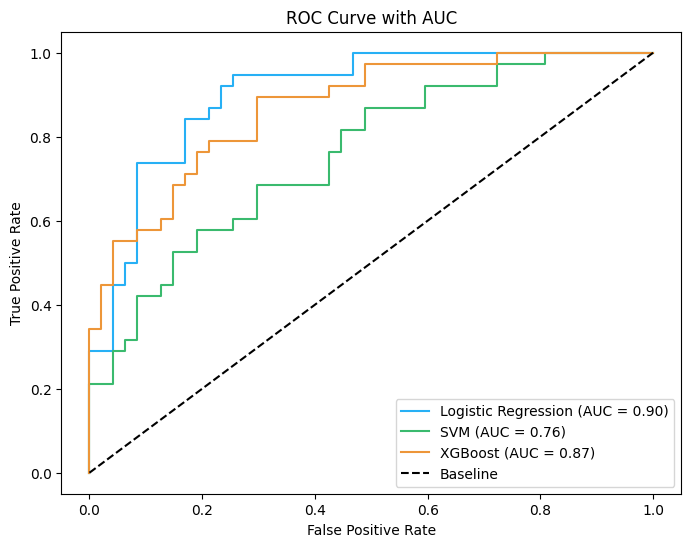

In [33]:
# --- AUC (ROC) Plot ---
plt.figure(figsize=(8,6))
plt.title("ROC Curve with AUC")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

for name, probs in y_probs.items():
    fpr, tpr, _ = roc_curve(y_test, probs)
    auc = roc_auc_score(y_test, probs)
    plt.plot(fpr, tpr, color=colors[name], label=f"{name} (AUC = {auc:.2f})")

# Baseline
plt.plot([0, 1], [0, 1], 'k--', label="Baseline")

plt.legend()

# --- Save High-Quality Image ---
plt.savefig("roc_auc_curve.png", dpi=1000, bbox_inches='tight')  # PNG at 300 DPI
plt.show()


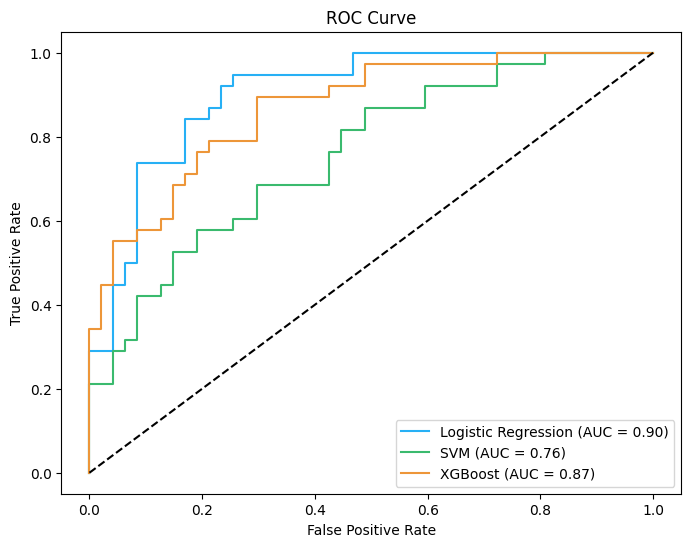

In [35]:
# --- Step 4: ROC Curve ---
plt.figure(figsize=(8,6))
for name, probs in y_probs.items():
    fpr, tpr, _ = roc_curve(y_test, probs)
    auc = roc_auc_score(y_test, probs)
    plt.plot(fpr, tpr, color=colors[name], label=f"{name} (AUC = {auc:.2f})")

# Baseline
plt.plot([0, 1], [0, 1], 'k--')

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()

# --- Save High-Quality Image ---
plt.savefig("roc_curve.png", dpi=1000, bbox_inches='tight')  # 300 DPI PNG
# plt.savefig("roc_curve.pdf", bbox_inches='tight')        # Optional: vector PDF

plt.show()


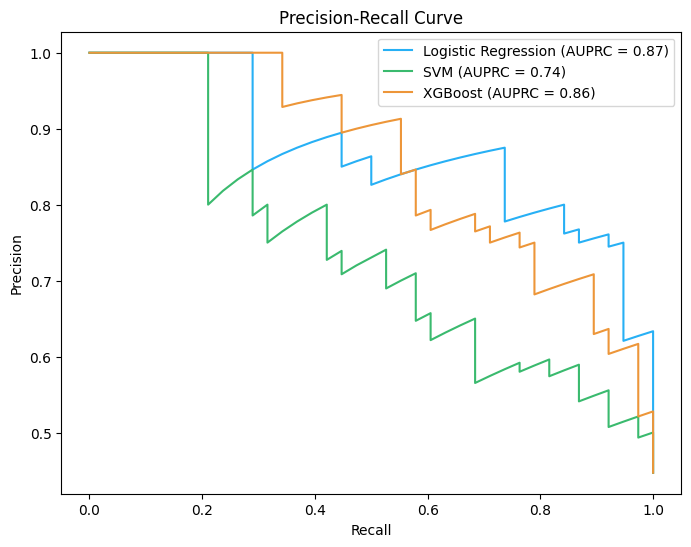

In [36]:
# --- Step 5: Precision-Recall Curve ---
plt.figure(figsize=(8,6))
for name, probs in y_probs.items():
    precision, recall, _ = precision_recall_curve(y_test, probs)
    auprc = average_precision_score(y_test, probs)
    plt.plot(recall, precision, color=colors[name], label=f"{name} (AUPRC = {auprc:.2f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()

# --- Save High-Quality Image ---
plt.savefig("precision_recall_curve.png", dpi=1000, bbox_inches='tight')  # High-resolution PNG
# plt.savefig("precision_recall_curve.pdf", bbox_inches='tight')        # Optional: Vector PDF

plt.show()


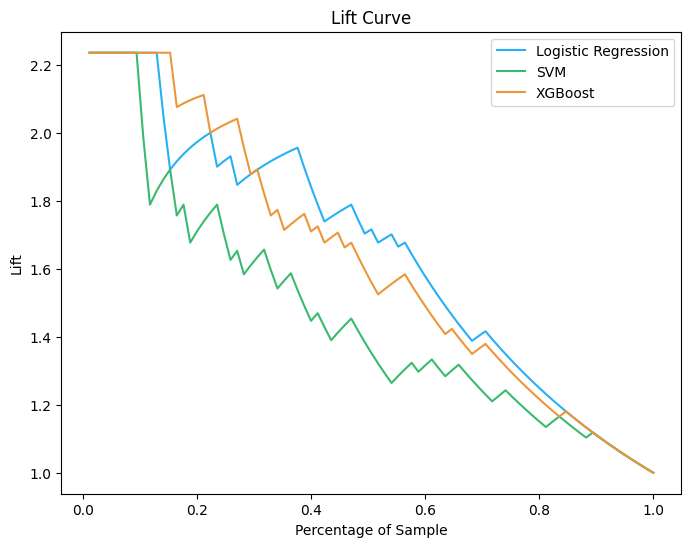

In [37]:
# --- Step X: Lift Curve ---
plt.figure(figsize=(8,6))
plt.title("Lift Curve")
plt.xlabel("Percentage of Sample")
plt.ylabel("Lift")

for name, probs in y_probs.items():
    # Prepare lift data
    df_lift = pd.DataFrame({"y_true": y_test, "y_prob": probs})
    df_lift = df_lift.sort_values("y_prob", ascending=False).reset_index(drop=True)
    df_lift["cum_response"] = df_lift["y_true"].cumsum()
    df_lift["perc_samples"] = (np.arange(len(df_lift)) + 1) / len(df_lift)
    df_lift["lift"] = df_lift["cum_response"] / (df_lift["perc_samples"] * df_lift["y_true"].sum())

    # Plot lift curve
    plt.plot(df_lift["perc_samples"], df_lift["lift"], color=colors[name], label=name)

plt.legend()

# --- Save High-Quality Image ---
plt.savefig("lift_curve.png", dpi=1000, bbox_inches='tight')  # PNG at 300 DPI
# plt.savefig("lift_curve.pdf", bbox_inches='tight')        # optional vector format

plt.show()


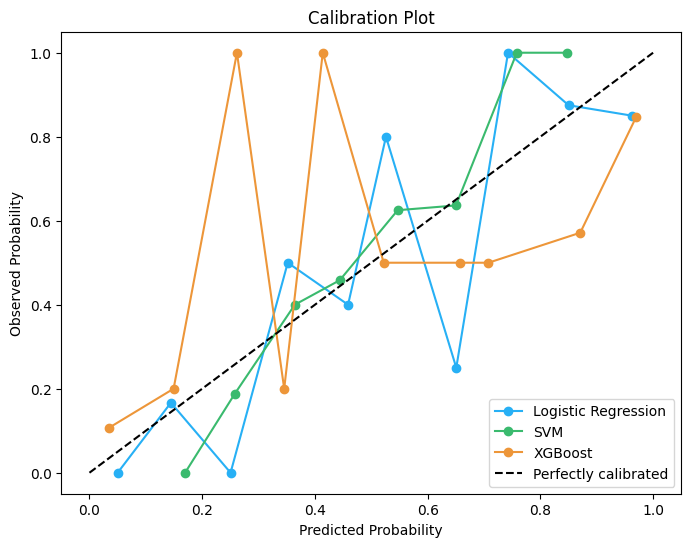

In [27]:

# --- Step 6: Calibration Plot ---
plt.figure(figsize=(8,6))
for name, probs in y_probs.items():
    prob_true, prob_pred = calibration_curve(y_test, probs, n_bins=10)
    plt.plot(prob_pred, prob_true, marker='o', color=colors[name], label=name)
plt.plot([0, 1], [0, 1], 'k--', label="Perfectly calibrated")
plt.xlabel("Predicted Probability")
plt.ylabel("Observed Probability")
plt.title("Calibration Plot")
plt.legend()
plt.show()